# AlphaPose and Downstream Modelling Pipeline

This notebook contains the entire pipeline for extracting pose features from a given video, along with applying all of our downstream models on those extracted pose features.

It represents the combination of all of our models, which can then be used to make predictions on new scenes and provide these to the API & Dashboard.

**Required TO-DO:**
- Everyone needs to integrate their downstream model(s) into this pipeline, through defining helper functions for preprocessing, prediction, and post-processing to give the outputs needed for the dashboard (see below code for instructions).
- Once done, this will give us a pipeline that can be run on either CPU or GPU as required! 👍 👍

## 1. Installation of dependencies / Importing packages

Install MXNet and Gluoncv libraries. If GPU is in use, also install mxnet-cu101 (requires runtime restart after):

In [1]:
import cv2
import mxnet as mx
import gluoncv

import os
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage.io
import tensorflow as tf
import tensorflow_hub as hub

from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord
from gluoncv.utils.viz import cv_plot_image, cv_plot_keypoints, plot_image
from gluoncv import utils

from matplotlib.lines import Line2D
from tensorflow import keras
from tqdm import tqdm

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/benjaminfraser/anaconda3/envs/nlp_cp/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


## 2. Setting up models, data and directories:

### 2.1 Image Classification Model Loading and Initialisation

**Note:** In order to get this working, you need to upload the pre-trained model to personal drive (I'll provide this as needed!)

Ensure the pre-trained mask classification model is located in the DRIVE_DATA_DIR, as defined below. It should be located in a folder called 'models' within this directory in your personal drive.

In [2]:
# get project path and other key directories for project
PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data')

# set path to test videos to use in this notebook
TEST_VIDEO_DIR = os.path.join(DATA_DIR, 'test_videos')

# define our model directory to obtain models as needed
MODEL_DIR = os.path.join(PROJECT_PATH, 'models')

Load pre-trained BiT model for mask classification:

In [3]:
# define folder that contains our trained model
saved_model_dir = os.path.join(MODEL_DIR, 'mask_clf_model')

# if not already done, load existing trained model
trained_module = hub.KerasLayer(saved_model_dir, trainable=False)

2022-03-19 19:49:24.004446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 19:49:35.553234: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 're_lu_48/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2022-03-19 19:49:35.553275: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


Set up main environment variables for the above mask classification model:

In [4]:
# if images are generally small (smaller than 96 x 96 on avg)
IMG_SIZE = (160, 160)
RESIZE_TO = 128
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# class id map for our mask model predictions
CLASS_ID_MAP = { 0 : 'No Mask',
                 1 : 'Mask'}

# color map dictionary for different classes
COLOR_MAP = {0 : [255.0, 0.0, 0.0],
             1 : [0.0, 255.0, 0.0]}

### 2.2 AlphaPose Model Loading and Initialisation

Load and initialise our AlphaPose model (select CPU or GPU as required!):

In [5]:
# initialise our alphapose model - either cpu or gpu subject to architecture
ctx = mx.cpu()
#ctx = mx.gpu()

# load and initialise object detector that feeds into AlphaPose
detector = get_model('ssd_512_mobilenet1.0_coco', pretrained=True, ctx=ctx)
detector.reset_class(classes=['person'], reuse_weights={'person':'person'})
detector.hybridize()

# Load and initialise AlphaPose model (estimates poses from dectector outputs)
estimator = get_model('alpha_pose_resnet101_v1b_coco', pretrained=True, ctx=ctx)
estimator.hybridize()

/Users/benjaminfraser/anaconda3/envs/nlp_cp/lib/python3.9/site-packages/mxnet/gluon/block.py:1627: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


We can now apply this AlphaPose model on a desired video / stream, by making predictions on each frame as it is received. We'll do this for an example video, as shown below:

### 2.3 Configure test video / scenes location for running our script:

Set path to .mp4 video to run pipeline on:

In [6]:
# set filename and path for chosen test video for this notebook
TEST_VIDEO_FILE = 'campus_1.mp4'
TEST_VIDEO_FILEPATH = os.path.join(TEST_VIDEO_DIR, TEST_VIDEO_FILE)

## 3. Defining helper functions for all downstream models

Within this section we require helper functions that allow each of our downstream models to pre-process, make predictions and post-process predictions from the extracted pose features.

### 3.1 Distance estimation helper **functions**

[Define all helper functions needed for preprocessing pose features and computing the distance results needed for the dashboard here...]

### 3.2 Distance estimation helper functions

[Define all helper functions needed for preprocessing pose features and computing the clustering results for the dashboard here...]

### 3.3 Pose classification helper functions

[Define all helper functions needed for preprocessing pose features and computing the status of people from pose features here...]

### 3.4 Image classification model helper functions

Helper functions are defined below for doing the following:
- Computing suitable head regions for all people in a scene using pose features
- Obtaining numpy array of all head regions from a given image array
- Obtaining a tensorflow tensor data object of the head regions, including preprocessing required for the classification model
- Pre-trained classification model functions for predicting masks for given input tensor of head regions.

In [7]:
def compute_head_boxes(pose_feats, factor=1.1):
    """ Obtain bounding box of heads using head average
        co-ordinates and torso length as a rough guide. 
    
    Args:
        pose_feats (mxnet array) : 2D array containing x and y co-ords
                columns for the 17 COCO keypoints (17 rows).
        factor (float) : factor to multiply torso length by for the
                        extracted head region (default 1.0)
    Returns:
        head_regions (np.array) : Array with head region box co-ordinates
            in the form [x_mins, y_mins, w, h] for each person (row).
    """
    # calculate the average head x and y coords
    head_x_avgs = pose_feats[:,:5,0].mean(axis=1).asnumpy().reshape(-1, 1)
    head_y_avgs = pose_feats[:,:5,1].mean(axis=1).asnumpy().reshape(-1, 1)
    head_avgs = np.column_stack([head_x_avgs, head_y_avgs])
    
    # calculate average shoulder co-ordinates
    shoulder_x_avgs = pose_feats[:,5:7,0].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_y_avgs = pose_feats[:,5:7,1].mean(axis=1).asnumpy().reshape(-1, 1)
    shoulder_avgs = np.column_stack([shoulder_x_avgs, shoulder_y_avgs])

    # calculate average waist (hip) co-ordinates
    waist_x_avgs = pose_feats[:,11:13,0].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_y_avgs = pose_feats[:,11:13,1].mean(axis=1).asnumpy().reshape(-1, 1)
    waist_avgs = np.column_stack([waist_x_avgs, waist_y_avgs])
    
    # calculate torso length using obtained co-ordinates
    torso_lengths = np.linalg.norm(shoulder_avgs - 
                    waist_avgs, axis=1).astype(int).reshape(-1, 1)
    
    # adjust torso lengths based on multiplier factor given
    torso_lengths = (torso_lengths*factor).astype(int).reshape(-1, 1)
    
    # find head box xmins, ymins, widths and heights
    x_mins = head_x_avgs - (torso_lengths / 2.0)
    y_mins = head_y_avgs - (torso_lengths / 2.0)
    w = torso_lengths.copy()
    h = torso_lengths.copy()
    
    # ensure xmins and y mins are not below zero:
    x_mins = np.maximum(x_mins, 0).astype(int)
    y_mins = np.maximum(y_mins, 0).astype(int)
    
    return np.column_stack([x_mins, y_mins, w, h])

In [8]:
def get_image_region_array(img_array, head_regions, 
                           normalise=True,
                           reshape_size=(RESIZE_TO, RESIZE_TO)):
    """ Helper function to gather head regions tensor.

    Args:
        df (pd.DataFrame) : pandas dataframe with pose results.
        img_name (str) : string containing exact name of image to plot.
        image_dir (str) : string containing path to image directory.
    
    Returns:
        tensor_stack (tf tensor) : tensor with resized image regions.
    """
    # create a list of numpy arrays with our images
    img_stack = [np.expand_dims(img_array[reg[1]:reg[1] + reg[3], 
                                          reg[0]:reg[0] + reg[2]], 
                                axis=0) 
                for reg in head_regions]

    # convert list of np arrays into ragged tensor
    tensor_stack = tf.ragged.constant(img_stack)

    # resize all images within our ragged tensor
    tensor_stack = tf.concat(
        [tf.image.resize(tensor_stack[i].to_tensor(), reshape_size) 
         for i in tf.range(tensor_stack.nrows())], axis=0)
    
    if normalise:
        tensor_stack = tensor_stack / 255.0
    
    return tensor_stack

In [9]:
# define softmax layer to use for normalising logit outputs
softmax_layer = tf.keras.layers.Softmax()

def model_predict_probs(model, image_batch, softmax=True):
    """ Helper function for making probability predictions 
        on an image batch 

    Args:
        model (TFHub Model) : Trained model for making predictions.
        image_batch (tf.tensor) : Tensor containing images for prediction.
        softmax (bool) : Whether to apply softmax activation or not.
    
    Returns:
        preds (np.array) : 2D output array of image predictions. First column 
                           is output for mask, second is for no_mask.
    """
    preds = model(image_batch)
    if softmax:
        return softmax_layer(preds).numpy()
    else:
        return preds

def get_prediction_labels(preds):
    """ Get output prediction labels (0 = no_mask, 1 = mask) """
    return tf.argmax(preds, axis=1)

Helper function for plotting image classification model predictions (useful for confirming results / implementation is correct):

In [10]:
def plot_mask_predictions(img, labels, pred_probs, 
                          head_regions,
                          color_map=COLOR_MAP, 
                          figsize=(7,6), 
                          legend=False):
    """ Helper function for plotting predictions for chosen images 
    
    Args:
        img (np.array) : Original image array.
        labels (np.array) : Predicted class labels.
        confidences (np.array) : Probabilities for predicted classes.
        color_map (dict) : dictionary mapping class output labels.
        figsize (tuple) : tuple of desired figure size to plot.
        legend (bool) : Whether to show legend or not, default false.
        box_col (str) : Column containing bbox regions to plot.
    """
    # keep only first column as predicted confidence
    confidences = list(pred_probs[:, 1])

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # plot each bbox and annotate confidence
    for i, box in enumerate(head_regions):
        
        # get co-ords for current bbox
        x_min, y_min, w, h = box
        
        # if mask, annotate green
        if labels[i] == 1:

            # plot current predicted bbox in green
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='g', 
                                        facecolor='none')

            ax.text(x_min, y_min - 5, f"{confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:green", "alpha": 0.4},
                    clip_on=True)
            
        else:
            # plot predicted non-mask in red
            pred_rect = mpatches.Rectangle((x_min, y_min), w, h, 
                                        linewidth=2, edgecolor='r', 
                                        facecolor='none')
        
            ax.text(x_min, y_min - 5, f"{1.0 - confidences[i]:.2f}", 
                    bbox={"facecolor": "tab:red", "alpha": 0.4},
                    clip_on=True)
        
        # add each bbox to plot
        ax.add_patch(pred_rect)
    
    # if legend chosen, annotate what class is which color
    if legend:
        # map color map colors to matplotlib style colors
        mpl_color_map = dict()
        for object_name in color_map.keys():
            mpl_color_map[object_name] = tuple([i/255 for i 
                                            in color_map[object_name]])
    
        # get object names and create legend lines for each class type
        object_ids = list(color_map.keys())

        object_names = [CLASS_ID_MAP[id] for id in object_ids]
    
        legend_lines = [Line2D([0],[0], 
                               color=mpl_color_map[object_ids[i]], 
                               lw=2) 
                        for i in range(len(object_ids))]
        plt.legend(legend_lines, object_names, loc='best')
        
    # hide our x and y-ticks on the axes
    ax.axis('off')

    ax.imshow(img)
    plt.show()
    return

## 4. Running AlphaPose on video example and obtaining all downstream modelling results:

All of our downstream models can be run on the video frames as they are processed by our AlphaPose model.

For each downstream model, we need to implement our modelling techniques (preprocessing, prediction & post-processing (if required)) after the AlphaPose model obtains pose extractions for each frame (see commented code below).

This process will be done on our example video (as uploaded in section 2.3 above!):

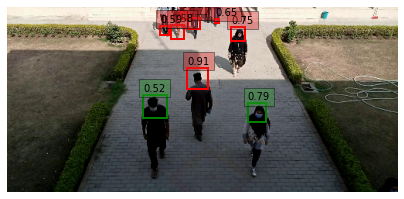

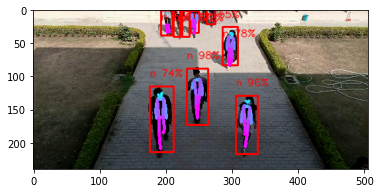

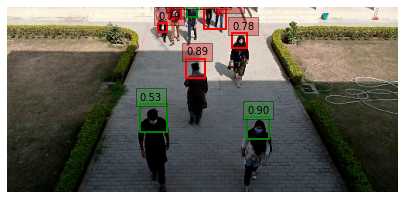

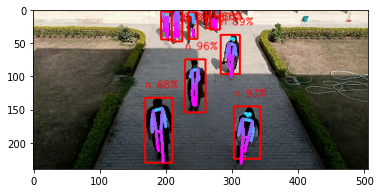

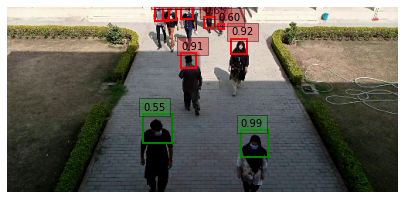

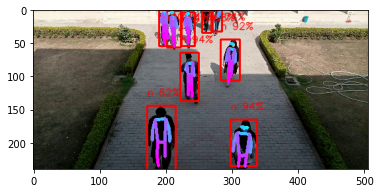

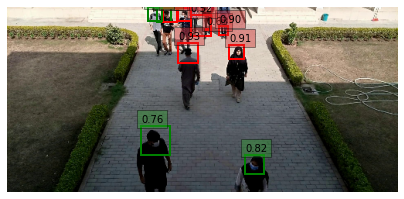

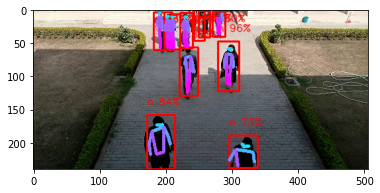

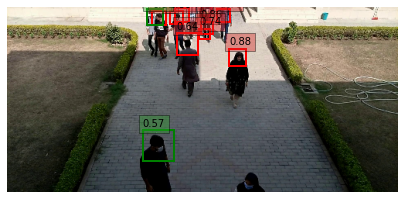

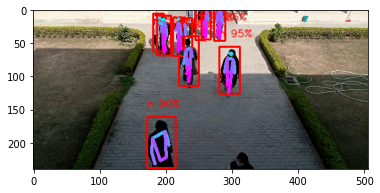

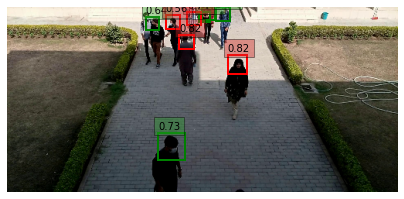

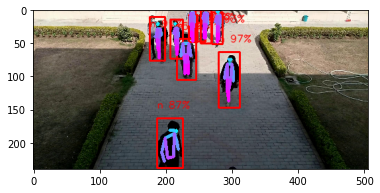

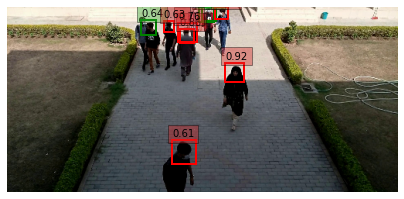

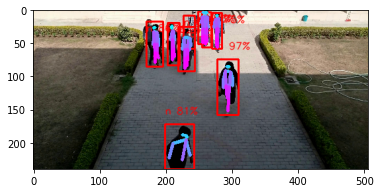

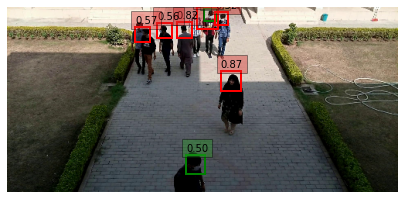

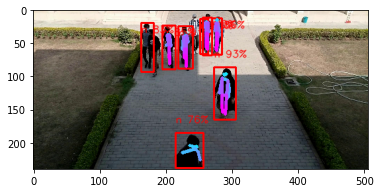

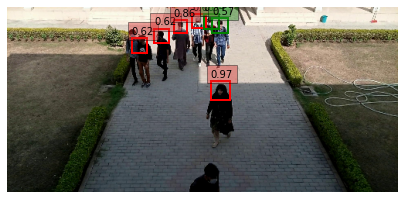

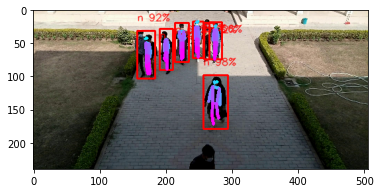

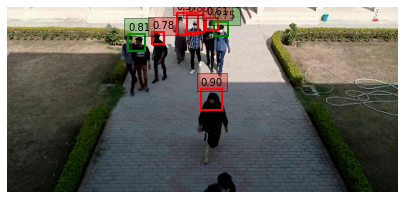

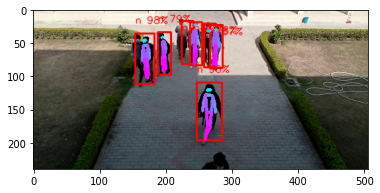

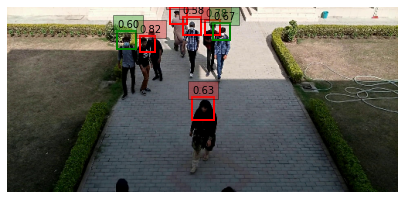

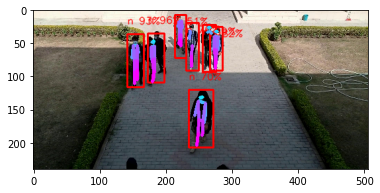

In [11]:
# load uploaded video into opencv:
cap = cv2.VideoCapture(TEST_VIDEO_FILEPATH)

# find fps of loaded video
fps = cap.get(cv2.CAP_PROP_FPS)

# define how often to make predictions (2 times per second by default)
MODELLING_FPS = 2

# initially current frame is zero
frame_count = 0

# dictionary for scene-summary results (e.g. person counts, mask %)
frame_results = {'image_id' : [],
                 'person_count' : [],
                 'mask_proportions' : []}

# dictionary for per-person level results (bbox, keypoints, mask_on etc.)
person_results = {'image_id' : [],
                  'bbox' : [],
                  'keypoints' : [],
                  'confidences' : [],
                  'mask_preds' : [],
                  'mask_pred_probs' : [],
                  'mask_head_regions' : []}

# whilst processing video, do the following loop..
while(True):

    # check video capture, and obtain current frame (image from video)
    ret, frame = cap.read()

    # if our video is still being processed, do the following...
    if(ret):

        # preprocess frame as required for object detector & AlphaPose
        frame = mx.nd.array(cv2.cvtColor(frame, 
                                         cv2.COLOR_BGR2RGB)).astype('uint8')
        x, frame = gluoncv.data.transforms.presets.ssd.transform_test(frame, 
                                                                      short=240)
        x = x.as_in_context(ctx)

        # obtain human bounding boxes using object detector
        class_IDs, scores, bounding_boxs = detector(x)

        # get pose estimations using AlphaPose
        pose_input, upscale_bbox = detector_to_alpha_pose(frame, class_IDs, 
                                                          scores, bounding_boxs)

        # add frame id, person count to frame-level results
        image_id = f"frame_{int(frame_count)}"
        n_people = upscale_bbox.shape[0]
        frame_results['image_id'].append(image_id)
        frame_results['person_count'].append(n_people)

        # add frame_id, person bbox to person-level results
        person_results['image_id'].append([image_id for x in range(n_people)])
        person_results['bbox'].append(upscale_bbox)

        # if we have predictions, obtain keypoint co-ords and confidences
        if upscale_bbox is not None:

            # obtain predicted heatmap
            predicted_heatmap = estimator(pose_input.as_in_context(ctx))

            # obtain keypoint co-ordinates from heatmap results
            pred_coords, confidence = heatmap_to_coord(predicted_heatmap, 
                                                       upscale_bbox)
            

            # add person keypoints and confidences to person-level results
            person_results['keypoints'].append(pred_coords.asnumpy())
            person_results['confidences'].append(confidence.asnumpy())

            ########################################################
            ######### DOWNSTREAM MODELLING PROCESSING AREA #########
            ########################################################
            
            ####### DISTANCE ESTIMATION / CLUSTERING (VALENTIN) #######
            # insert code for distance estimation / clustering here #


            ####### POSE STATUS CLASSIFICATION (TONGFEI) #######
            # insert code for distance estimation / clustering here #
            

            ####### MASK CLASSIFICATION CODE (BEN) #######

            # obtain head regions boxes from our pose features
            head_regions = compute_head_boxes(pred_coords)

            # get extract tensor of head regions from original frame
            region_tensor = get_image_region_array(frame, head_regions)
            
            # obtain probabilities (softmax normalised) from model
            pred_probs = model_predict_probs(trained_module, region_tensor)

            # obtain hard class labels from our probabilities
            preds = get_prediction_labels(pred_probs).numpy()

            # plot our predicted mask results with original image
            plot_mask_predictions(frame, preds, pred_probs, head_regions)

            # get mask proportion in scene, add to our total results
            mask_prop = np.array(np.bincount(preds)[1] / preds.shape[0])

            # append mask results to per-person results
            person_results['mask_preds'].append(preds)
            person_results['mask_pred_probs'].append(pred_probs)
            person_results['mask_head_regions'].append(head_regions)

            # add mask proportions to frame-results
            frame_results['mask_proportions'].append(mask_prop)


            ############################################
            ######### DOWNSTREAM MODELLING END #########
            ############################################
            
            # annotate our original frame with alphapose extracted keypoints
            img = cv_plot_keypoints(frame, pred_coords, confidence, class_IDs, 
                                    bounding_boxs, scores,
                                    box_thresh=0.5, keypoint_thresh=0.2)
            
            # plot alphapose results
            plot_image(img)

        # if no alphapose keypoints found, just plot the frame (image)
        else:
            plot_image(img)
        
        # increment current frame by amount selected by MODELLING_FPS
        frame_count += fps / MODELLING_FPS
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_count))

    # break loop if video is not available / ended
    else:
        break

    if cv2.waitKey(1) == 27:
        break

# empty video capture cache
cap.release()
cv2.destroyAllWindows()

The plotting and displaying of the results as performed above is not required - it's simply there to aid checking of results / validation. 

As long as we include the results from each downsteam model in the final results dataframes / JSON objects, we've done everything that is needed in this process.

## 5. Conversion of final results into Pandas dataframes, and exporting to JSON objects:

Lets convert the results obtained from this into a final form, suitable for further analysis / passing to the API & Dashboard:

In [12]:
final_frame_results = {}

# standardise frame-level results as np arrays for consistency
for key in frame_results.keys():
        final_frame_results[key] = np.array(frame_results[key])

# convert frame-level results to dataframe for ease of analysis
final_frame_results = pd.DataFrame(final_frame_results)

# preview results format
final_frame_results.head()

,image_id,person_count,mask_proportions
0,frame_0,9,0.222222
1,frame_12,9,0.333333
2,frame_25,9,0.222222
3,frame_37,11,0.363636
4,frame_50,10,0.200000


In [13]:
final_person_results = {}

# convert mask results into np array form and flatten
for key in person_results.keys():
        final_person_results[key] = np.concatenate(person_results[key], axis=0)
        final_person_results[key] = final_person_results[key].tolist()

# convert final person-level results to dataframe
final_person_results = pd.DataFrame(final_person_results)

# preview results
final_person_results.head()

,image_id,bbox,keypoints,confidences,mask_preds,mask_pred_probs,mask_head_regions
0,frame_0,"[227.0, 75.0, 269.0, 186.0]","[[245.375, 95.8125], [244.5, 92.34375], [249.7...","[[0.00973547250032425], [0.00821388978511095],...",0,"[0.9103890657424927, 0.08961094170808792]","[233, 79, 27, 27]"
1,frame_0,"[301.0, 116.0, 344.0, 230.0]","[[324.2916564941406, 139.15625], [325.1875, 13...","[[0.7227594256401062], [0.8381087779998779], [...",1,"[0.2131674438714981, 0.7868325710296631]","[311, 125, 24, 24]"
2,frame_0,"[283.0, 16.0, 313.0, 92.0]","[[299.25, 36.1875], [299.875, 35.0], [298.625,...","[[0.7538436055183411], [0.7873037457466125], [...",0,"[0.7530317306518555, 0.24696829915046692]","[290, 26, 18, 18]"
3,frame_0,"[170.0, 101.0, 218.0, 229.0]","[[191.0, 133.0], [193.0, 129.0], [190.0, 131.0...","[[0.37460657954216003], [0.3376145660877228], ...",1,"[0.4771084785461426, 0.5228915214538574]","[176, 114, 30, 30]"
4,frame_0,"[236.0, 0.0, 252.0, 40.0]","[[242.0, 16.875], [243.6666717529297, 35.625],...","[[0.001975949853658676], [0.001581756165251135...",0,"[0.7748896479606628, 0.22511036694049835]","[234, 14, 15, 15]"


Now that we have these as pandas dataframes, they can be exported easily into JSON objects, like so:

In [14]:
frame_json_results = final_frame_results.to_json()
person_json_results = final_person_results.to_json()

In [15]:
print(frame_json_results)

{"image_id":{"0":"frame_0","1":"frame_12","2":"frame_25","3":"frame_37","4":"frame_50","5":"frame_62","6":"frame_75","7":"frame_87","8":"frame_100","9":"frame_112","10":"frame_125"},"person_count":{"0":9,"1":9,"2":9,"3":11,"4":10,"5":9,"6":9,"7":8,"8":7,"9":7,"10":7},"mask_proportions":{"0":0.2222222222,"1":0.3333333333,"2":0.2222222222,"3":0.3636363636,"4":0.2,"5":0.5555555556,"6":0.3333333333,"7":0.25,"8":0.2857142857,"9":0.2857142857,"10":0.2857142857}}


In [16]:
print(person_json_results)

{"image_id":{"0":"frame_0","1":"frame_0","2":"frame_0","3":"frame_0","4":"frame_0","5":"frame_0","6":"frame_0","7":"frame_0","8":"frame_0","9":"frame_12","10":"frame_12","11":"frame_12","12":"frame_12","13":"frame_12","14":"frame_12","15":"frame_12","16":"frame_12","17":"frame_12","18":"frame_25","19":"frame_25","20":"frame_25","21":"frame_25","22":"frame_25","23":"frame_25","24":"frame_25","25":"frame_25","26":"frame_25","27":"frame_37","28":"frame_37","29":"frame_37","30":"frame_37","31":"frame_37","32":"frame_37","33":"frame_37","34":"frame_37","35":"frame_37","36":"frame_37","37":"frame_37","38":"frame_50","39":"frame_50","40":"frame_50","41":"frame_50","42":"frame_50","43":"frame_50","44":"frame_50","45":"frame_50","46":"frame_50","47":"frame_50","48":"frame_62","49":"frame_62","50":"frame_62","51":"frame_62","52":"frame_62","53":"frame_62","54":"frame_62","55":"frame_62","56":"frame_62","57":"frame_75","58":"frame_75","59":"frame_75","60":"frame_75","61":"frame_75","62":"frame_75

These JSON strings can now be packaged and sent to an API (or any desired location) as required.

When received by our API, the results can easily be decoded and read again into pandas, like so:

In [17]:
received_frame_results = pd.read_json(frame_json_results)
received_frame_results.head()

,image_id,person_count,mask_proportions
0,frame_0,9,0.222222
1,frame_12,9,0.333333
2,frame_25,9,0.222222
3,frame_37,11,0.363636
4,frame_50,10,0.200000


In [18]:
received_person_results = pd.read_json(person_json_results)
received_person_results.head()

,image_id,bbox,keypoints,confidences,mask_preds,mask_pred_probs,mask_head_regions
0,frame_0,"[227.0, 75.0, 269.0, 186.0]","[[245.375, 95.8125], [244.5, 92.34375], [249.7...","[[0.0097354725], [0.0082138898], [0.0101852482...",0,"[0.9103890657, 0.0896109417]","[233, 79, 27, 27]"
1,frame_0,"[301.0, 116.0, 344.0, 230.0]","[[324.2916564941, 139.15625], [325.1875, 137.3...","[[0.7227594256000001], [0.838108778], [0.73062...",1,"[0.2131674439, 0.786832571]","[311, 125, 24, 24]"
2,frame_0,"[283.0, 16.0, 313.0, 92.0]","[[299.25, 36.1875], [299.875, 35.0], [298.625,...","[[0.7538436055000001], [0.7873037457000001], [...",0,"[0.7530317307000001, 0.24696829920000002]","[290, 26, 18, 18]"
3,frame_0,"[170.0, 101.0, 218.0, 229.0]","[[191.0, 133.0], [193.0, 129.0], [190.0, 131.0...","[[0.37460657950000004], [0.3376145661], [0.377...",1,"[0.47710847850000004, 0.5228915215000001]","[176, 114, 30, 30]"
4,frame_0,"[236.0, 0.0, 252.0, 40.0]","[[242.0, 16.875], [243.6666717529, 35.625], [2...","[[0.0019759499], [0.0015817562], [0.0026788285...",0,"[0.774889648, 0.2251103669]","[234, 14, 15, 15]"


These results are now suitable to use in the API and Dashboard as needed.

---

**Still TO-DO:**
- Integrate all downstream models in this script, including distance estimation, pose classification and group clustering. We need a way of adding these results to the results dictionaries above as appropriate.
- Package final results better in JSON format for API.
- Include any additional info from alphapose that could be useful, like confidence levels for person bounding boxes.